# 2016-00-03 07:55:37 

## Setup 

In [1]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy  
import scikits.bootstrap as bootstrap
from scipy import stats
pd.__version__

u'0.17.1'

In [2]:
%matplotlib inline

In [3]:
import scipy  
from scipy import stats
import scikits.bootstrap as bootstrap  
scipy.__version__

'0.16.1'

### Data Specifics

In [4]:
ls

1_3_2016_Averages.ipynb  1_3_2016_oldcode.ipynb  raw_data/


In [5]:
averages_header_row=['update',
                     'merit',
                     'gestation_time',
                     'fitness',
                     'repro_rate',
                     'size',
                     'copied_size',
                     'executed_size',
                     'abundance',
                     'prop_birthers',
                     'prop_breedtrue',
                     'genotype_depth',
                     'generation',
                     'neutral_metric',
                     'lineage_label',
                     'true_rep_rate'
                     ]

### Functions

In [6]:
averages_header_row=['update',
                     'merit',
                     'gestation_time',
                     'fitness',
                     'repro_rate',
                     'size',
                     'copied_size',
                     'executed_size',
                     'abundance',
                     'prop_birthers',
                     'prop_breedtrue',
                     'genotype_depth',
                     'generation',
                     'neutral_metric',
                     'lineage_label',
                     'true_rep_rate'
                     ]
# read data into a dict collection of arrays of data frames.
# the dict is indexed by the treatment
# each item in the array under the dict is a data-frame that is
# a replicate of that treatment.
# treatment_pattern is "P_"+prob+"/hgtbonus"
# columns is the set of columns we want to keep.
def read_treatments(treatment_pattern, target_filename, columns=None, verbose=False, names=None):
    if verbose:
        print "READ TREATMENTS"
    data = {}
    for folder in glob.glob("raw_data/"+treatment_pattern):
        if verbose:
            print folder
        name = folder.split("/")[2]
        if verbose:
            print name
        data[name] = []

#        print folder + "/*/data*/"+target_filename
#        print glob.glob(folder + "/*/data*/"+target_filename)
        for datafile in glob.glob(folder + "/*/data*/"+target_filename):
            #print datafile
            bleh = pd.read_csv(datafile,
                               names=names, 
                               delimiter=" ", 
                               comment='#',
                               usecols=columns,
                               index_col=False)
            data[name].append(bleh)
    if verbose:
        print "DONE"
    return data

## tests
thing = read_treatments("P_1/hgtbonus", "average.dat", 
                        columns=['update', 'fitness'], 
                        names=averages_header_row, verbose=True)
print thing.keys()
print thing['hgtbonus']
thing = read_treatments("P_1/*", "average.dat", names=averages_header_row, verbose=True)
print thing.keys()
print thing['hgtbonus']


READ TREATMENTS
raw_data/P_1/hgtbonus
hgtbonus
DONE
['hgtbonus']
[      update       fitness
0          0      0.000000
1        100      0.249657
2        200      0.246714
3        300      0.247288
4        400      0.247958
5        500      0.247670
6        600      0.247993
7        700      0.248031
8        800      0.248274
9        900      0.248766
10      1000      0.249601
11      1100      0.250268
12      1200      0.250354
13      1300      0.250665
14      1400      0.252621
15      1500      0.258791
16      1600      0.271098
17      1700      0.289394
18      1800      0.321867
19      1900      0.381661
20      2000      0.584110
21      2100      1.169280
22      2200     14.152900
23      2300     88.039200
24      2400    141.354000
25      2500    182.981000
26      2600    200.880000
27      2700    214.104000
28      2800    216.605000
29      2900    221.296000
...      ...           ...
971    97100  23976.600000
972    97200  23542.600000
973    97300  23

In [7]:
# dataframes are an array of dataframes, one per replicate.
def group_treatment(data_frames, verbose=False):
    ## data_frames is a [] of dataframes that are all replicates of each other.
    #print data_frames
    if verbose:
        print "Incoming:"
        print len(data_frames)    
    aggregated_dataframe = (pd.concat(data_frames, axis=1, keys=range(len(data_frames)))
                            .swaplevel(0, 1, axis=1)
                            .sortlevel(axis=1)
                            .groupby(level=0, axis=1))
    if verbose:
        print "Out:"
        print aggregated_dataframe.head()

    return aggregated_dataframe


## Tests
treatments = read_treatments("P_1/*", "average.dat", 
                        columns=['update', 'fitness'], 
                        names=averages_header_row)
print treatments.keys()

aggregated_treatments = {}
for df_set_key in treatments.keys():
    print df_set_key
    aggregated_treatments[df_set_key] = group_treatment(treatments[df_set_key], verbose=True)
    #print aggregated_treatments[df_set_key].describe()


['control', 'bonus', 'hgt', 'hgtbonus']
control
Incoming:
50
Out:
      update                                                                  \
          0       1       2       3       4       5       6       7       8    
0          0       0       0       0       0       0       0       0       0   
1        100     100     100     100     100     100     100     100     100   
2        200     200     200     200     200     200     200     200     200   
3        300     300     300     300     300     300     300     300     300   
4        400     400     400     400     400     400     400     400     400   
50      5000    5000    5000    5000    5000    5000    5000    5000    5000   
51      5100    5100    5100    5100    5100    5100    5100    5100    5100   
52      5200    5200    5200    5200    5200    5200    5200    5200    5200   
53      5300    5300    5300    5300    5300    5300    5300    5300    5300   
54      5400    5400    5400    5400    5400    5400  

In [8]:
def calc_stats(aggregated_dataframe, verbose=False):
    # calculate stats for data

    means = aggregated_dataframe.mean()
    stderrs = aggregated_dataframe.std().div(np.sqrt(len(aggregated_dataframe))).mul(2.0)
    
    if verbose:
        print "Means:"
        print means.head()
        print "STDErrs:"
        print stderrs.head()
    
    return (means, stderrs)

## Tests
treatments = read_treatments("P_1/hgtbonus", "average.dat", 
                        columns=['update', 'fitness'], 
                        names=averages_header_row)
print treatments.keys()

aggregated_treatments = {}
aggregated_means = {}
for df_set_key in treatments.keys():
    aggregated_treatments[df_set_key] = group_treatment(treatments[df_set_key], verbose=False)
    (means, stds) = calc_stats(aggregated_treatments[df_set_key], verbose=True)

   

['hgtbonus']
Means:
   update   fitness
0       0  0.000000
1     100  0.247445
2     200  0.246842
3     300  0.246385
4     400  0.246411
STDErrs:
   update   fitness
0       0  0.000000
1       0  0.003273
2       0  0.002114
3       0  0.002134
4       0  0.001833


In [51]:
def bootstrap_error( data , verbose=False, debug=False):
    x = np.array(data)
    if debug:
        print len(x)
        #print x
    X = [] ## estimates
    mean = np.mean(x)
    for xx in xrange(1000): ## do this 1000 times
        X.append( np.mean( x[np.random.randint(len(x),size=len(x))] ) )
    if debug:
        print len(X)
        #print X
    mean_X = np.mean(X)           
    ## re-sample means are not guaranteed to be quite right.
    ## Conf 0.95, loc=sample mean, scale = (np.std(X, ddof=1)/np.sqrt(len(X)))
    conf_int = stats.norm.interval(0.95, loc=mean_X, scale=stats.sem(X))
    
    err_size = max( (mean_X - conf_int[0]), (conf_int[1] - mean_X) )
    
    if (np.isnan(err_size)):
        err_size = 0
    
    if debug:
        print err_size
    #    print conf_int

    #return conf_int
    return err_size

def calc_bootstrap_error(aggDF, verbose=False, debug=False):
    bsErrDF = pd.DataFrame()
    for key, subset in aggDF:
        if verbose:
            print "Key: " + key
            print subset.head()
            print len(subset)
        
        CIs = []
        for i in range(len(subset)):
            vals = subset.iloc[i].values
            if debug:
                print vals
            CIs.append(bootstrap_error(vals, verbose=verbose, debug=debug))
        
        if verbose:
            print CIs
            
        bsErrDF[key] = CIs
        #bleh = subset.apply(lambda x:bootstrap.ci(data=x.values))
        #print bleh

    if verbose:
        print "BOOTSTRAP VALS:"
        print bsErrDF.head()
        
    return bsErrDF


## Tests
treatments = read_treatments("P_1/hgtbonus", "average.dat", 
                        columns=['update', 'fitness'], 
                        names=averages_header_row)
print treatments.keys()

aggregated_treatments = {}
aggregated_means = {}
for df_set_key in treatments.keys():
    aggregated_treatments[df_set_key] = group_treatment(treatments[df_set_key], verbose=False)
    #(means, stds) = calc_stats(aggregated_treatments[df_set_key], verbose=True)
    bootstrap_err = calc_bootstrap_error(aggregated_treatments[df_set_key], verbose=True)

['hgtbonus']
Key: update
  update                                              ...                  \
      0    1    2    3    4    5    6    7    8    9  ...    40   41   42   
0      0    0    0    0    0    0    0    0    0    0 ...     0    0    0   
1    100  100  100  100  100  100  100  100  100  100 ...   100  100  100   
2    200  200  200  200  200  200  200  200  200  200 ...   200  200  200   
3    300  300  300  300  300  300  300  300  300  300 ...   300  300  300   
4    400  400  400  400  400  400  400  400  400  400 ...   400  400  400   

                                      
    43   44   45   46   47   48   49  
0    0    0    0    0    0    0    0  
1  100  100  100  100  100  100  100  
2  200  200  200  200  200  200  200  
3  300  300  300  300  300  300  300  
4  400  400  400  400  400  400  400  

[5 rows x 50 columns]
1001
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Analysis

### Basic Sanity Checks

In [10]:
treatments = read_treatments("P_1/hgtbonus", "average.dat", 
                        columns=['update', 'fitness'], 
                        names=averages_header_row)
print treatments.keys()

aggregated_treatments = {}
aggregated_means = {}
aggregated_bootstraps = {}
for df_set_key in treatments.keys():
    aggregated_treatments[df_set_key] = group_treatment(treatments[df_set_key])
    (means, stds) = calc_stats(aggregated_treatments[df_set_key])
    aggregated_means[df_set_key] = means
    aggregated_bootstraps[df_set_key] = calc_bootstrap_error(aggregated_treatments[df_set_key])

['hgtbonus']


In [11]:
aggregated_bootstraps

{'hgtbonus':           update                           fitness
 0     (nan, nan)                        (nan, nan)
 1     (nan, nan)  (0.247426894224, 0.247466482856)
 2     (nan, nan)  (0.246823976516, 0.246849736324)
 3     (nan, nan)    (0.24636659957, 0.24639285631)
 4     (nan, nan)  (0.246409335237, 0.246431515643)
 5     (nan, nan)  (0.246504318614, 0.246523312826)
 6     (nan, nan)  (0.247571045752, 0.247638395648)
 7     (nan, nan)  (0.252956651756, 0.253632212404)
 8     (nan, nan)  (0.260141379016, 0.261606503024)
 9     (nan, nan)  (0.270532948818, 0.273218123502)
 10    (nan, nan)  (0.308810963767, 0.316248143993)
 11    (nan, nan)    (0.56462798704, 0.60548764784)
 12    (nan, nan)  (0.805052708335, 0.874282794225)
 13    (nan, nan)    (1.04869600111, 1.15325993013)
 14    (nan, nan)    (1.24429916303, 1.36777712537)
 15    (nan, nan)    (1.41296944213, 1.54111216195)
 16    (nan, nan)    (1.55353011301, 1.68753242519)
 17    (nan, nan)    (1.80091007192, 1.94163186496)


### Comparing Probability Treatments

In [52]:
probs = ['1', '0.75', '0.5', '0.25', '0.1', '0.01', '0.001', '0']
means_dict = {}
bootstraps_dict = {}
for prob in probs:    
    treatments = read_treatments("P_"+prob+"/hgtbonus", "average.dat", 
                            columns=['update', 'fitness'], 
                            names=averages_header_row)
    print prob
    aggregated_treatments = {}
    aggregated_means = {}
    aggregated_bootstraps = {}
    for df_set_key in treatments.keys():
        print df_set_key
        aggregated_treatments[df_set_key] = group_treatment(treatments[df_set_key])
        (means, stds) = calc_stats(aggregated_treatments[df_set_key])
        aggregated_means[df_set_key] = means
        aggregated_bootstraps[df_set_key] = calc_bootstrap_error(aggregated_treatments[df_set_key], 
                                                                 verbose=False)    
    #print prob
    means_dict[prob] = aggregated_means
    bootstraps_dict[prob] = aggregated_bootstraps

1
hgtbonus
0.75
hgtbonus
0.5
hgtbonus
0.25
hgtbonus
0.1
hgtbonus
0.01
hgtbonus
0.001
hgtbonus
0
hgtbonus


In [54]:
bootstraps_dict

{'0': {'hgtbonus':       update       fitness
  0          0  0.000000e+00
  1          0  2.672144e-05
  2          0  2.509052e-04
  3          0  9.572948e-03
  4          0  1.448350e+01
  5          0  5.655430e+03
  6          0  1.300518e+04
  7          0  2.352908e+04
  8          0  5.626004e+04
  9          0  1.030299e+05
  10         0  1.408004e+05
  11         0  1.748656e+05
  12         0  2.043528e+05
  13         0  2.322432e+05
  14         0  2.592042e+05
  15         0  2.816666e+05
  16         0  2.948351e+05
  17         0  2.959628e+05
  18         0  3.131876e+05
  19         0  3.349066e+05
  20         0  3.466705e+05
  21         0  3.467052e+05
  22         0  3.575470e+05
  23         0  3.720447e+05
  24         0  3.710032e+05
  25         0  3.851051e+05
  26         0  4.026061e+05
  27         0  4.099175e+05
  28         0  4.188794e+05
  29         0  4.208036e+05
  ...      ...           ...
  971        0  5.434198e+09
  972        0  5.676494e+

In [55]:
means_dict['0'].keys()

['hgtbonus']

In [56]:
means_dict['0.01']['hgtbonus'].describe()

,update,fitness
count,1001.000000,1.001000e+03
mean,50000.000000,1.301548e+11
std,28910.811127,2.070260e+11
min,0.000000,0.000000e+00
25%,25000.000000,1.733552e+09
50%,50000.000000,2.686705e+10
75%,75000.000000,6.862639e+10
max,100000.000000,6.499078e+11


In [57]:
means_dict['0.75']['hgtbonus'].describe()

,update,fitness
count,1001.000000,1001.000000
mean,50000.000000,1537648.810470
std,28910.811127,1117329.054458
min,0.000000,0.000000
25%,25000.000000,332067.357186
50%,50000.000000,1566540.718400
75%,75000.000000,2716050.552000
max,100000.000000,3362736.383400


### Just the mean lines

In [ ]:
def plot_across_treatments(treatmentset, treatment, column):
    #treatmentset = set of probabilities to plot ['1', '0.1'...]
    #treatment = which treatment to plot "hgt" "hgtbonus" etc.
    #column = which column to plot "fitness", "gestation_time" etc.
    data = {}
    means = {}
    errors = {}
    bootstrap_errors = {}
    
    combined_dataframes = pd.DataFrame()
    
    for prob in treatmentset:
        data[prob] = read_glob("P_"+prob+"/*", "average.dat")
        #print "HI"
        means[prob], errors[prob] = calc_stats(data[prob])
        bootstrap_errors[prob] = calc_bootstrap(data[prob], column)
    
    for treatmentset in sorted(means.keys()):
        combined_dataframes[treatmentset] = means[treatmentset][treatment][column]
        
    ax = combined_dataframes.plot(logy=True, 
                              title="fitnesses at various hgtbonus probabilities", 
                              yerr=bootstrap_errors
                             )
    ax.set_xlabel("100x Updates"),
    ax.set_ylabel("log fitness")    


In [ ]:
plot_across_treatments(['1', '0.75', '0.5', '0.25', '0.1', '0.01', '0.001', '0'],
                      "hgtbonus", "fitness")

In [19]:
probs = ['1', '0.75', '0.5', '0.25', '0.1', '0.01', '0.001', '0']
means_dict = {}
bootstraps_dict = {}
for prob in probs:    
    treatments = read_treatments("P_"+prob+"/hgtbonus", "average.dat", 
                            columns=['update', 'fitness'], 
                            names=averages_header_row)
    print prob
    aggregated_treatments = {}
    aggregated_means = {}
    aggregated_bootstraps = {}
    for df_set_key in treatments.keys():
        print df_set_key
        aggregated_treatments[df_set_key] = group_treatment(treatments[df_set_key])
        (means, stds) = calc_stats(aggregated_treatments[df_set_key])
        aggregated_means[df_set_key] = means
        aggregated_bootstraps[df_set_key] = calc_bootstrap_error(aggregated_treatments[df_set_key], 
                                                                 verbose=False)    
    #print prob
    means_dict[prob] = aggregated_means
    bootstraps_dict[prob] = aggregated_bootstraps

1
hgtbonus
0.75
hgtbonus
0.5
hgtbonus
0.25
hgtbonus
0.1
hgtbonus
0.01
hgtbonus
0.001
hgtbonus
0
hgtbonus


KeyError: '0'

In [59]:
combined_dataframes = pd.DataFrame()
combined_df_boots = pd.DataFrame()
treatment = "hgtbonus"
column = "fitness"
for treatmentset in sorted(means_dict.keys()):
    #if (treatmentset not in ['0.25', '0.5', '0.75']):
    combined_dataframes[treatmentset] = means_dict[treatmentset][treatment][column]
    combined_df_boots[treatmentset] = bootstraps_dict[treatmentset][treatment][column]

In [60]:
combined_dataframes.head()

,0,0.001,0.01,0.1,0.25,0.5,0.75,1
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.247914,0.247914,0.247914,0.247758,0.247639,0.247636,0.247546,0.247445
2,0.271819,0.271619,0.271016,0.261938,0.253782,0.249792,0.247559,0.246842
3,0.868752,0.776248,1.524982,0.310645,0.262267,0.250666,0.247549,0.246385
4,256.776754,640.124953,6970.376734,0.459349,0.275056,0.252454,0.247913,0.246411


In [61]:
combined_df_boots.head()

,0,0.001,0.01,0.1,0.25,0.5,0.75,1
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000027,0.000027,0.000028,0.000023,0.000022,0.000022,0.000020,0.000019
2,0.000251,0.000251,0.000219,0.000145,0.000071,0.000031,0.000018,0.000013
3,0.009573,0.008211,0.044541,0.000410,0.000073,0.000029,0.000016,0.000013
4,14.483501,34.951139,263.086710,0.002712,0.000173,0.000027,0.000012,0.000011


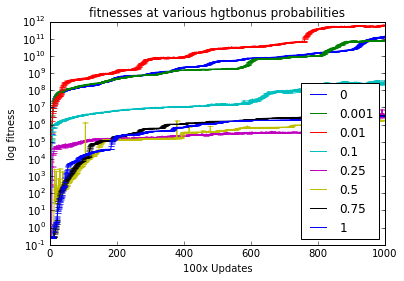

In [62]:
ax = combined_dataframes.plot(logy=True, 
                              title="fitnesses at various hgtbonus probabilities", 
                              yerr=combined_df_boots
                             )
ax.set_xlabel("100x Updates"),
ax.set_ylabel("log fitness")

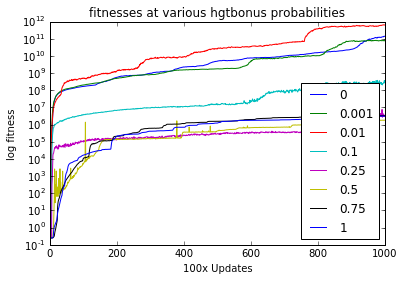

In [63]:
ax = combined_dataframes.plot(logy=True, 
                              title="fitnesses at various hgtbonus probabilities"
                             )
ax.set_xlabel("100x Updates"),
ax.set_ylabel("log fitness")

In [ ]:
combined_dataframes.head()

In [ ]:
combined_dataframes.std()

In [ ]:
sorted(combined_dataframes.columns)

In [ ]:
ax = combined_dataframes.plot(logy=True, 
                              title="fitnesses at various hgtbonus probabilities", 
                              yerr=combined_dataframes.std()
                             )
ax.set_xlabel("100x Updates"),
ax.set_ylabel("log fitness")

In [ ]:
dir(combined_dataframes.plot())

In [ ]:
combined_dataframes.describe()

### Now for something new

In [ ]:
from pandas.tools.plotting import bootstrap_plot

In [ ]:
bootstrap_plot(combined_dataframes['0.01'], size=20, samples=500, color='grey')